In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_alfa_svm_db.csv'))
print(df.shape)
print(df.columns)

(1350, 38)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')


In [5]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
print(len(COLS_CM))

COL_Y = 'Test.Poison'
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

28


In [6]:
N_ITER_SEARCH = 100
N_FOLD = 5
THRESHOLD = 0.00

In [7]:
def get_pivot_table(df, positive_threshold=THRESHOLD):
    # Step 0: Add difficulty levels
    df = df.copy()
    df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
    cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
    df['Difficulty'] = df['Difficulty'].astype(cat_type)

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[df['Rate'] == 0].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        idx_train = df[df['Data.Base'].isin(data_train)].index
        idx_test = df[df['Data.Base'].isin(data_test)].index
        assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Step 3: Find threshold
    y_true_ = (df['Rate'] > positive_threshold).astype(int)
    y_score_ = df['Train.Poison'] - df['Prediction']
    fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
    idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
    threshold = thresholds[idx_t]
    print(f'threshold: {threshold}')

    # Step 4: Populate pivot table
    results = (df['Train.Poison'] - df['Prediction']) >= threshold
    df_ = df[['Difficulty', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    df_pivot
    return df_pivot, threshold

In [8]:
pivot_tables = []

for workspace in [f'diva_{i:02d}' for i in range(1, 4)]:
    print(workspace)

    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth', f'synth_{att}_db.csv'))

        tab, _ = get_pivot_table(df_, positive_threshold=THRESHOLD)
        tab.to_csv(os.path.join(path_output, f'synth_pivot_{workspace}_{att}.csv'))

        tab = tab.reset_index()
        pivot_tables.append(tab)

diva_01
alpha=0.000100
threshold: 0.38301134685952565
alpha=0.015500
threshold: 0.35972864011204464
diva_02
alpha=0.052800
threshold: 0.3915011384988609
alpha=0.000300
threshold: 0.33395091448171
diva_03
alpha=0.081600
threshold: 0.38005500059172315
alpha=0.011200
threshold: 0.31010378144420203


In [9]:
pivot_1 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_1

Dataset Difficulty,Easy,Normal,Hard
Poisoning Rate,,,
0.00,0.0,1.0,6.0
0.05,0.0,2.0,16.0
0.10,0.0,12.0,30.0
0.15,2.0,18.0,36.0
0.20,6.0,27.0,39.0
0.25,10.0,28.0,40.0
0.30,15.0,32.0,42.0
0.35,17.0,30.0,42.0
0.40,19.0,29.0,41.0


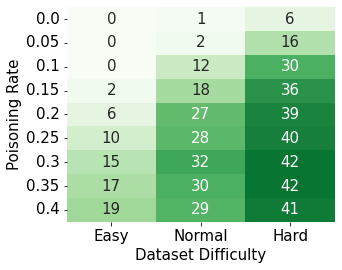

In [10]:
FONTSIZE = 15
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.heatmap(pivot_1, ax=ax, annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=50, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
plot_output = os.path.join(path_output, 'synth_heatmap.svg')
plt.savefig(plot_output, dpi=300)

In [11]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'synth_falfa_nn_db.csv'))
noise_rate = df['Data'].apply(lambda x: float(x.split('_')[6][2:]))
df['Noise.Rate'] = noise_rate

In [12]:
# Find parameter
param = {'alpha': loguniform(1e-4, 10),}
X = df[COLS_CM]
y = df[COL_Y]
regressor = linear_model.Ridge()
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(X, y)

best_estimator_ = param_search.best_estimator_.get_params()
alpha = np.round(best_estimator_['alpha'], 4)
print(alpha)

0.0075


In [13]:
df['Prediction'] = 0.

# Split by clean data
idx_clean = df[df['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(idx_clean):
    idx_train_clean = idx_clean[i_train]
    idx_test_clean = idx_clean[i_test]

    data_train = df.loc[idx_train_clean, 'Data.Base']
    data_test = df.loc[idx_test_clean, 'Data.Base']

    idx_train = df[df['Data.Base'].isin(data_train)].index
    idx_test = df[df['Data.Base'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

    X_train = df.loc[idx_train, COLS_CM]
    y_train = df.loc[idx_train, COL_Y]
    X_test = df.loc[idx_test, COLS_CM]
    y_test = df.loc[idx_test, COL_Y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

# Apply clipping
df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

In [14]:
df_ = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)]
dif_00 = (df_['Train.Poison'] - df_['Prediction'])
print(dif_00.min(), dif_00.max())

threshold = np.quantile(dif_00, 0.95)

print(f'threshold: {threshold}')

-0.00347222222222221 0.6394062191775807
threshold: 0.38147410382590946


In [15]:
results = (df['Train.Poison'] - df['Prediction']) > threshold
df_ = df[['Noise.Rate', 'Rate']].copy()
df_['Prediction'] = results.astype(int)
df_ = df_.rename(columns = {'Noise.Rate':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
df_grouped = df_grouped.reset_index()
pivot_2 = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
pivot_2

Noise Label Rate,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40
Poisoning Rate,,,,,,,,,
0.00,3,3,8,12,13,17,20,24,25
0.05,8,6,11,14,21,20,19,24,23
0.10,18,19,21,21,25,24,25,25,29
0.15,17,23,24,27,26,29,28,29,28
0.20,25,26,25,28,30,27,28,27,27
0.25,23,27,27,29,31,31,32,29,31
0.30,27,28,34,33,32,33,28,35,31
0.35,25,25,29,27,33,29,34,31,28
0.40,25,24,30,28,32,28,31,30,29


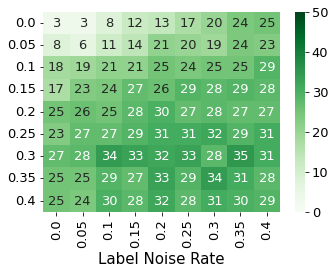

In [16]:
FONTSIZE = 13
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(pivot_2, ax=ax, annot=True, fmt='d', cmap="Greens", vmin=0, vmax=50)
plt.yticks(rotation=0)
plt.xlabel('Label Noise Rate', fontsize=FONTSIZE+2)
# plt.ylabel('Poisoning Rate', fontsize=FONTSIZE+2)
plt.ylabel('')
plt.tight_layout()
plot_output = os.path.join(path_output, 'synth_heatmap_noise.svg')
plt.savefig(plot_output, dpi=300)

Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap.svg


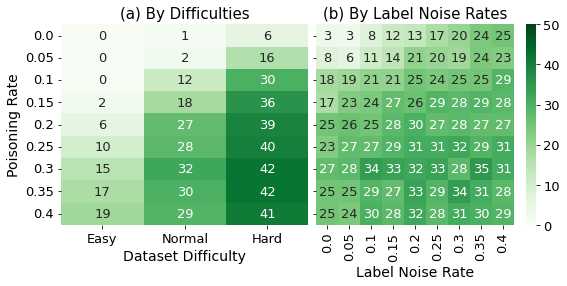

In [17]:
FONTSIZE = 13
FIGSIZE = (8, 4)
X_LABELS = ['Dataset Difficulty', 'Label Noise Rate']
TITLES = ['(a) By Difficulties', '(b) By Label Noise Rates']

plt.rcParams["font.size"] = FONTSIZE
fig, axes = plt.subplots(1, 2, sharey=True, figsize=FIGSIZE)

sns.heatmap(pivot_1, ax=axes[0], annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=50, cbar=False)
axes[0].set_ylabel('Poisoning Rate', fontsize=FONTSIZE+1)

sns.heatmap(pivot_2, ax=axes[1], annot=True, fmt='d', cmap="Greens", vmin=0, vmax=50)
axes[1].set_ylabel('')

for i, ax in enumerate(axes):
    ax.set_xlabel(X_LABELS[i], fontsize=FONTSIZE+1)
    ax.set_title(TITLES[i], fontsize=FONTSIZE+2)

plt.tight_layout(pad=0.6)
plot_heatmap = os.path.join(path_output, 'synth_heatmap.svg')
plt.savefig(plot_heatmap, dpi=300)
print(f'Save to: {plot_heatmap}')